In [1]:
#makes sure to reload our modules on each execution

%load_ext autoreload 
%autoreload 1
%aimport gans, preprocessing, sourceSeparation, thresholding, testingPipeline

import concurrent.futures
import matplotlib.pyplot as plt
import torch
import pickle
import numpy as np
import math
import sklearn
from collections import defaultdict
import json

In [2]:
# data init

# dataset
baseDatasetPath = "../data/datasets"
inclusionThreshold = 0.5
includedSims = 24

# iters to run
iters = 5

snrs=range(1,7)

#SDs to test
sdMuls = list(range(1, 6))

# gans
batchSize = 64
baseModelPath = "../data/models"
epochs = 5
noiseDim = 200

#results
resultsPath = "../data/results"

Generating dataset for iteration 1
Processing Simulation: 1, 
Generating non-drowned segment of dataset
Generating dataset with snr 1


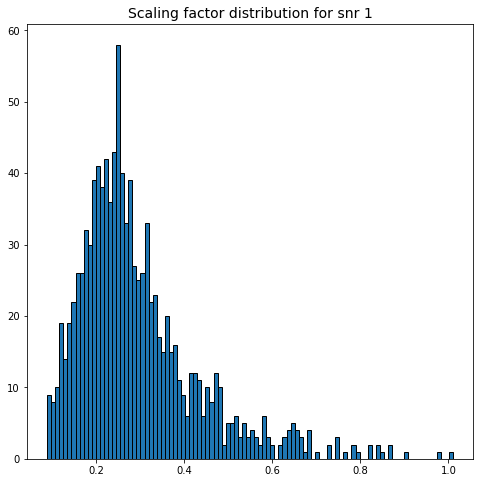

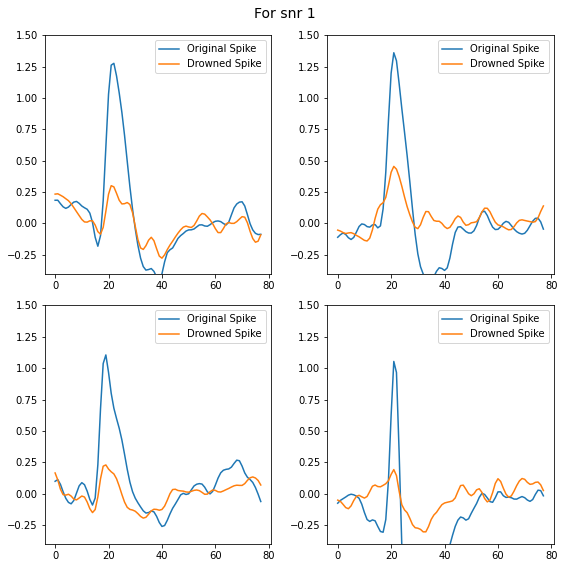

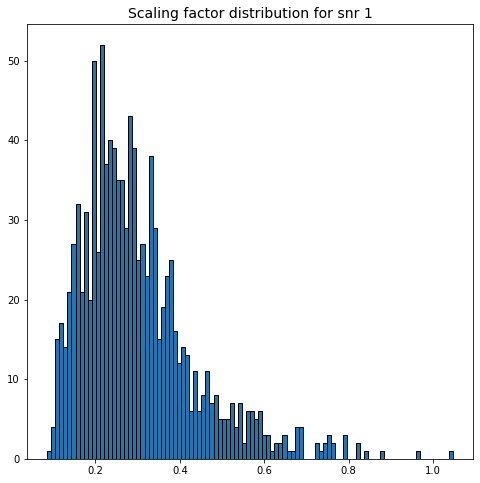

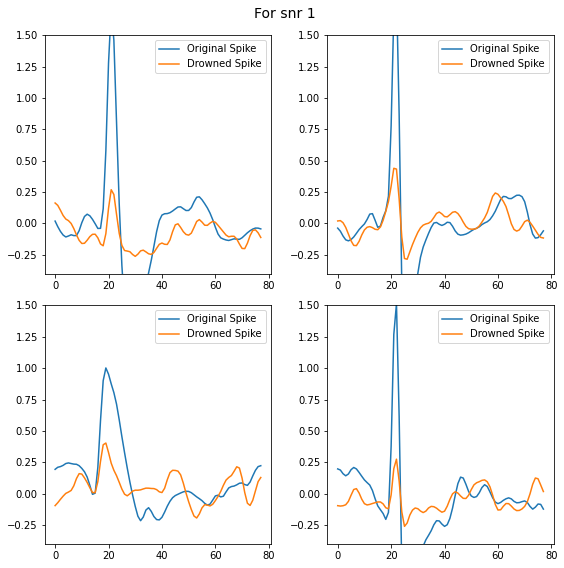

Generating dataset with snr 2


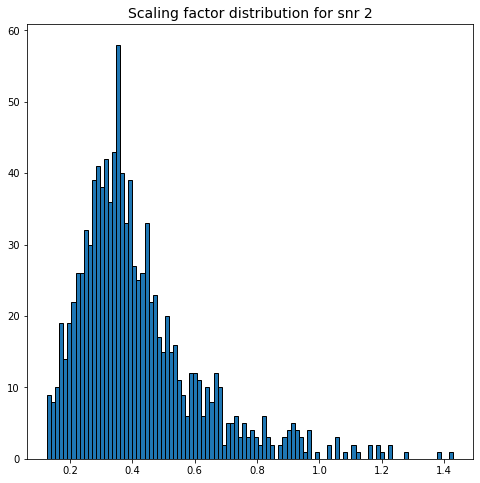

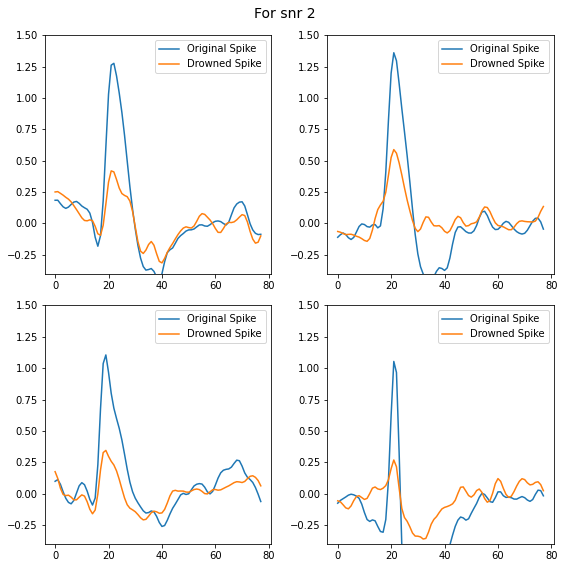

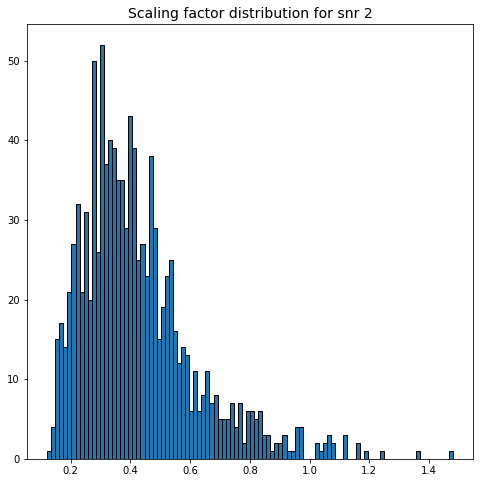

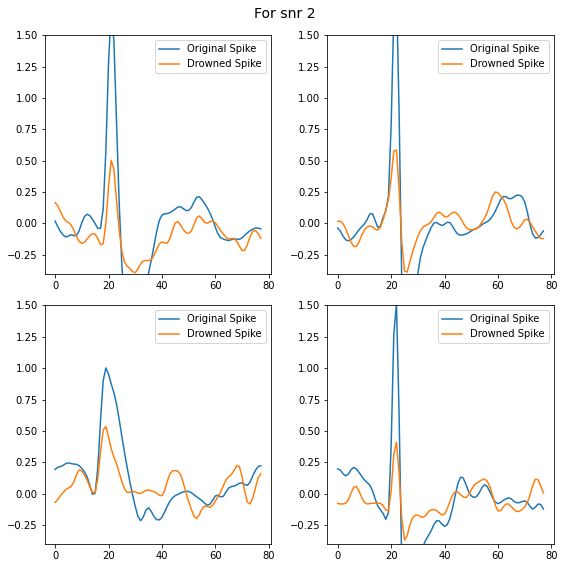

Generating dataset for iteration 2
Processing Simulation: 1, 
Generating non-drowned segment of dataset
Generating dataset with snr 1


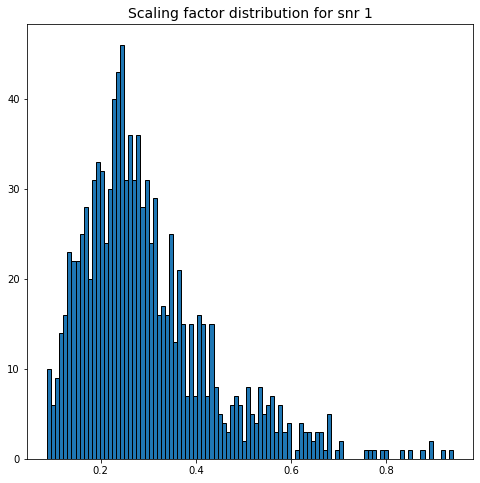

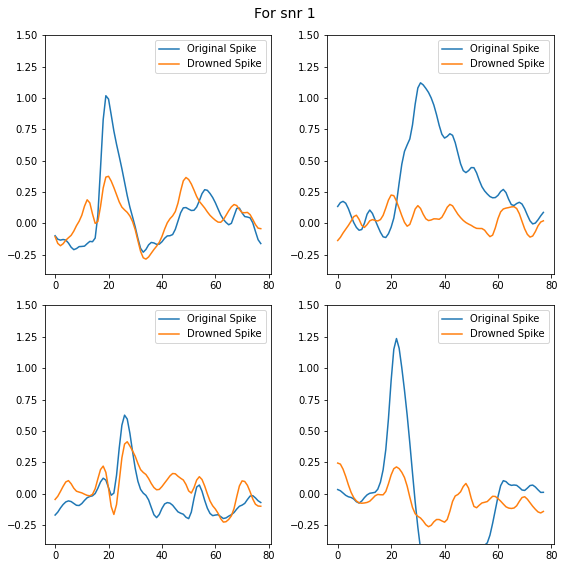

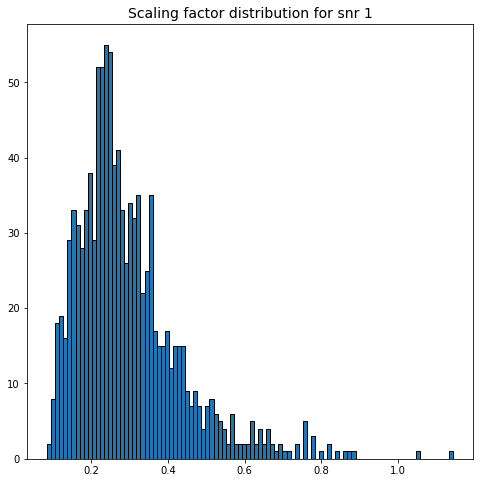

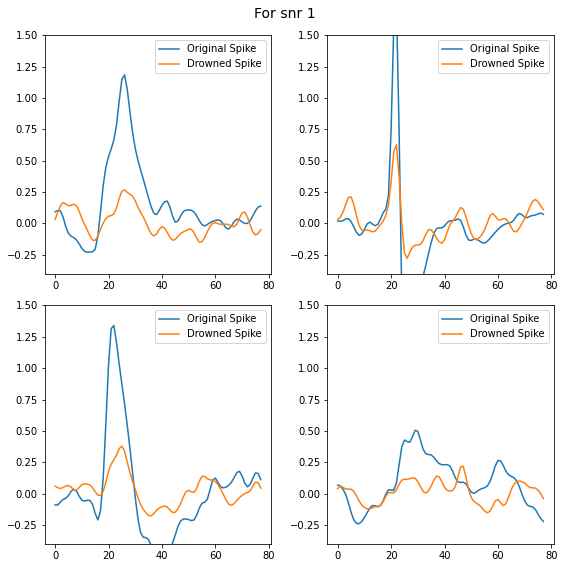

Generating dataset with snr 2


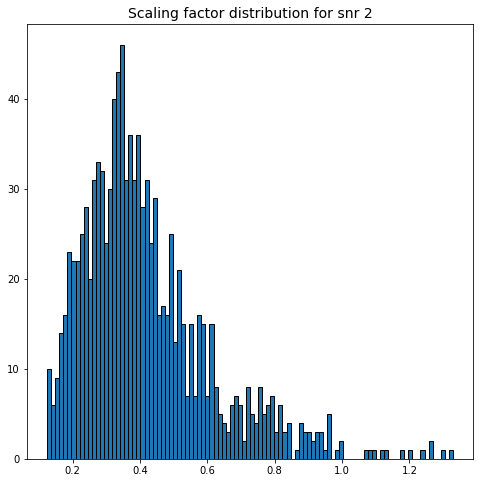

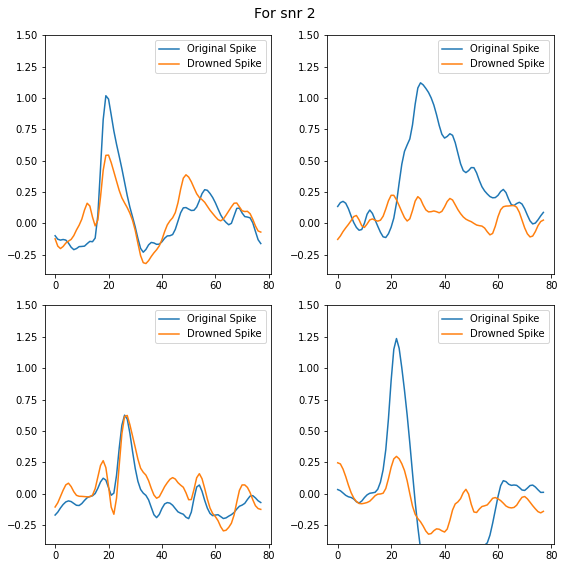

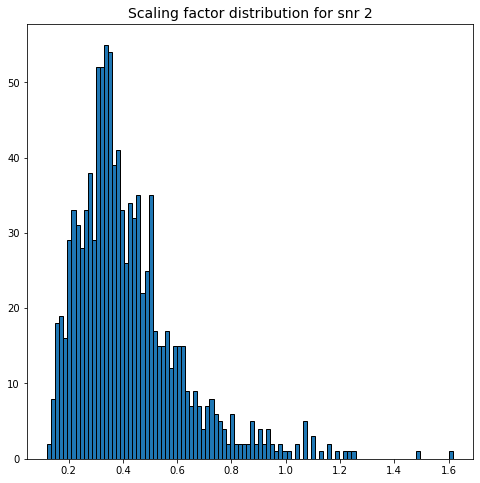

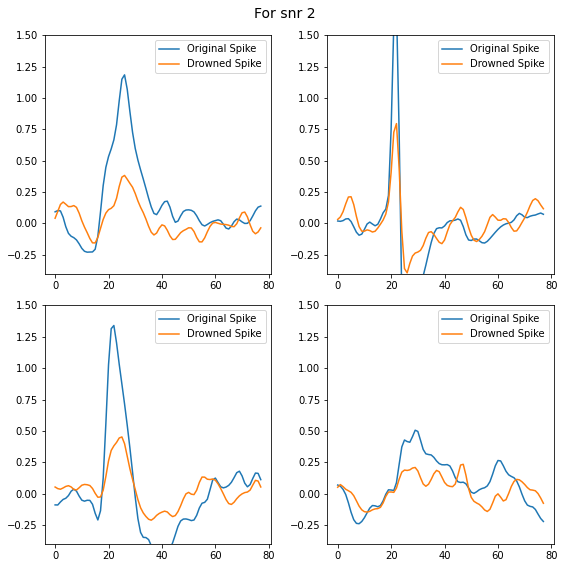

In [8]:
# generate datasets
preprocessing.it_genLoaders( 
    batchSize,
    includedSims,
    doPrint=True,
    snrs=snrs,
    inclusionThreshold=0.5,
    iterations=iters,
    baseDatasetPath=baseDatasetPath
)

In [31]:
# run thresholding pipeline iters times

def thresholdDefault2():
    return {}

def thresholdDefault1():
    return defaultdict(thresholdDefault2)

thresholdingRes = defaultdict(thresholdDefault1)

for i in range(1, iters + 1):
    print(f"\nIteration {i}\n")
    
    trainSpikesLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-non-drowned-trainSpikesLoader.pickle", "rb"))
    trainBgLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-non-drowned-trainBgLoader.pickle", "rb"))
    valBgLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-non-drowned-valBgLoader.pickle", "rb"))
    testBgLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-non-drowned-testBgLoader.pickle", "rb"))
    
    for snr in snrs:
        print(f"\nThresholding dataset with snr {snr}\n")

        valSpikesLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-snr-{snr}-valSpikesLoader.pickle", "rb"))
        testSpikesLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-snr-{snr}-testSpikesLoader.pickle", "rb"))

        mean, sd = thresholding.computeThreshold(trainSpikesLoader, valSpikesLoader, testSpikesLoader, trainBgLoader, valBgLoader, testBgLoader)

        for sdMul in sdMuls:
            pred = thresholding.thresholdDatasets(mean, sdMul * sd, testSpikesLoader, testBgLoader)

            labels = np.concatenate(([1 for _ in range(0,len(testSpikesLoader.dataset))],[0 for _ in range(0,len(testBgLoader.dataset))]),axis=0)

            confusionMatrix = testingPipeline.confusionMatrix(labels,pred)

            accuracy, sensitivity, specificity, f1 = testingPipeline.metrics(confusionMatrix)

            thresholdingRes[i][sdMul][snr] = [confusionMatrix, accuracy, sensitivity, specificity, f1]

            print(f"Results for {sdMul} sd")
            print(confusionMatrix)
            print(f"Accuracy: {accuracy}")
            print(f"Sensitivity: {sensitivity}")
            print(f"Specificity: {specificity}")

pickle.dump(thresholdingRes, open(f"{resultsPath}/thresholdingRes.pickle", "wb"))



Iteration 1


Thresholding dataset with snr 1

Results for 1 sd
[[ 4452 16202]
 [ 1082 19572]]
Accuracy: 0.5815822600948969
Sensitivity: 0.9476130531616151
Specificity: 0.21555146702817857
Results for 2 sd
[[16910  3744]
 [10379 10275]]
Accuracy: 0.6581049675607631
Sensitivity: 0.4974823278783771
Specificity: 0.8187276072431491
Results for 3 sd
[[20187   467]
 [17000  3654]]
Accuracy: 0.5771521254962719
Sensitivity: 0.17691488331558053
Specificity: 0.9773893676769633
Results for 4 sd
[[20598    56]
 [19447  1207]]
Accuracy: 0.5278638520383461
Sensitivity: 0.05843904328459378
Specificity: 0.9972886607920984
Results for 5 sd
[[20648     6]
 [20235   419]]
Accuracy: 0.5099980633291372
Sensitivity: 0.020286627287692458
Specificity: 0.999709499370582

Thresholding dataset with snr 2

Results for 1 sd
[[ 4541 16113]
 [  241 20413]]
Accuracy: 0.6040960588747942
Sensitivity: 0.9883315580517091
Specificity: 0.21986055969787935
Results for 2 sd
[[17009  3645]
 [ 6247 14407]]
Accuracy: 0.7605306


Iteration 1

Training GANs
Separating validation noise
torch.Size([1065, 80])
Separating test noise
torch.Size([1065, 80])

Separating dataset with snr 1

Separating validation spikes
torch.Size([1065, 80])


/home/adodon/Documents/Workspaces/Repositories/UTCN/licenta/implementation/sourceseparation_misc/testingPipeline.py:28: RuntimeWarning: invalid value encountered in long_scalars
  precision   = confusionMatrix[1][1] / (confusionMatrix[1][1] + confusionMatrix[0][1])


Threshold for best F1: 0.2
Threshold: 0.2
Sensitivity: 0.9051643192488263
Specificity: 0.6093896713615023
Accuracy: 0.7572769953051643
Separating test spikes
torch.Size([1065, 80])


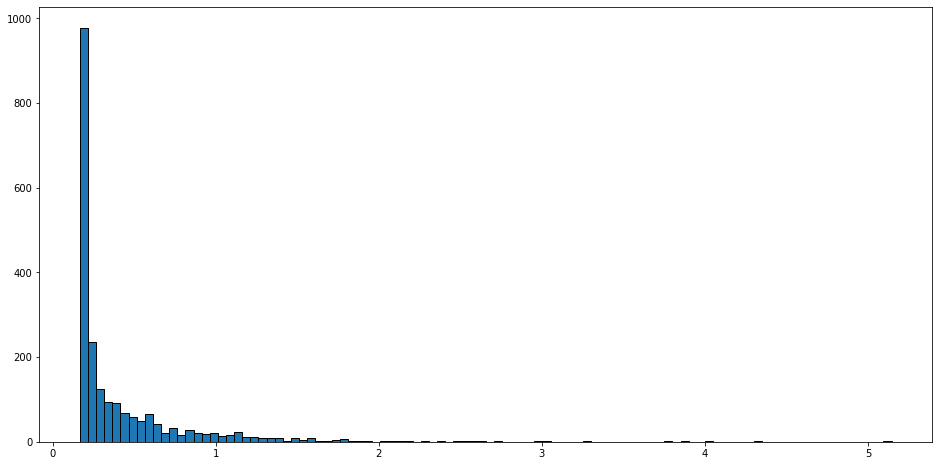

Threshold for best F1: 0.2
Threshold: 0.2
Sensitivity: 0.9192488262910798
Specificity: 0.6347417840375587
Accuracy: 0.7769953051643192

Separating dataset with snr 2

Separating validation spikes
torch.Size([1065, 80])
Threshold for best F1: 0.25
Threshold: 0.25
Sensitivity: 0.9098591549295775
Specificity: 0.8413145539906103
Accuracy: 0.8755868544600939
Separating test spikes
torch.Size([1065, 80])


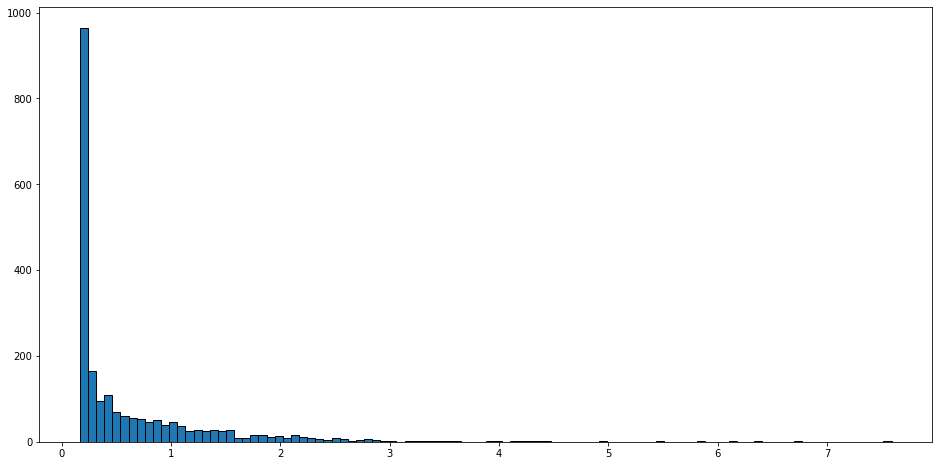

Threshold for best F1: 0.25
Threshold: 0.25
Sensitivity: 0.9248826291079812
Specificity: 0.8488262910798122
Accuracy: 0.8868544600938967


In [24]:
# run the separation pipeline iters times

def defaultSep():
    return {}

separationRes = defaultdict(defaultSep)


for i in [1]:
    print(f"\nIteration {i}\n")
    
    print("Training GANs")
    #gans.spawnTrainingProcesses(baseDatasetPath, i, baseModelPath, batchSize, noiseDim, epochs)

    genSpike = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=80, outputSize=80)
    criticSpike = gans.CriticWgan(inputSize=80, hiddenSize=40)
    genSpike.load_state_dict(torch.load(f"{baseModelPath}/it-{i}-gen-spike.pth"))
    genSpike.to(gans.device)
    criticSpike.load_state_dict(torch.load(f"{baseModelPath}/it-{i}-critic-spike.pth"))
    criticSpike.to(gans.device)
    
    genNoise = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=80, outputSize=80)
    criticNoise = gans.CriticWgan(inputSize=80, hiddenSize=40)
    genNoise.load_state_dict(torch.load(f"{baseModelPath}/it-{i}-gen-noise.pth"))
    genNoise.to(gans.device)
    criticNoise.load_state_dict(torch.load(f"{baseModelPath}/it-{i}-critic-noise.pth"))
    criticNoise.to(gans.device)
    
    valBgLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-non-drowned-valBgLoader.pickle", "rb"))
    testBgLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-non-drowned-testBgLoader.pickle", "rb"))
    
    # separating noise as it is the same for all snrs
    
    print("Separating validation noise")
    
    (cleanextractedSpikesValidationBg,cleanextractedNoisesValidationBg) = sourceSeparation.maxlikelihood_separatesources(
        generators=[genSpike, genNoise],
        loader_mix=valBgLoader,
        epochs=3000
    )
    
    print("Separating test noise")
    
    (cleanextractedSpikesTestBg,cleanextractedNoisesTestBg) = sourceSeparation.maxlikelihood_separatesources(
        generators=[genSpike, genNoise],
        loader_mix=testBgLoader,
        epochs=3000
    )

    for snr in snrs:
        print(f"\nSeparating dataset with snr {snr}\n")
        
        valSpikesLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-snr-{snr}-valSpikesLoader.pickle", "rb"))
        testSpikesLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-snr-{snr}-testSpikesLoader.pickle", "rb"))
        
        print("Separating validation spikes")
        
        (cleanextractedSpikesValidationSpikes,cleanextractedNoisesValidationSpikes) = sourceSeparation.maxlikelihood_separatesources(
            generators=[genSpike, genNoise],
            loader_mix=valSpikesLoader,
            epochs=3000
        )
        
        valExtractedSpikes = np.concatenate((cleanextractedSpikesValidationSpikes,cleanextractedSpikesValidationBg),axis=0)
        valExtractedSpikes = torch.from_numpy(valExtractedSpikes)
        vallabel = np.concatenate(([1 for _ in cleanextractedSpikesValidationSpikes],[0 for _ in cleanextractedSpikesValidationBg]),axis=0)
        
        valThreshold, _, _, _, _, _ = testingPipeline.interpretSeparation(valExtractedSpikes, criticSpike, vallabel,method="energy")
        
        print("Separating test spikes")
        
        (cleanextractedSpikesTestSpikes,cleanextractedNoisesTestSpikes) = sourceSeparation.maxlikelihood_separatesources(
            generators=[genSpike, genNoise],
            loader_mix=testSpikesLoader,
            epochs=3000
        )
        
        testExtractedSpikes = np.concatenate((cleanextractedSpikesTestSpikes,cleanextractedSpikesTestBg),axis=0)
        testExtractedSpikes = torch.from_numpy(testExtractedSpikes)
        testlabel = np.concatenate(([1 for _ in cleanextractedSpikesTestSpikes],[0 for _ in cleanextractedSpikesTestBg]),axis=0)
        
        _, confusionMatrix, accuracy, sensitivity, specificity, f1 = testingPipeline.interpretSeparation(testExtractedSpikes, criticSpike, testlabel,test=True, testThreshold=valThreshold,method="energy")

        separationRes[i][snr] = [confusionMatrix, accuracy, sensitivity, specificity, f1]

pickle.dump(separationRes, open(f"{resultsPath}/separationRes.pickle", "wb"))
        
        

In [32]:
# Interpret thresholding results
#avgs -> metric -> sd -> values for specific snr
avgs = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0)))

thIt = 0

for it in thresholdingRes:
    thIt += 1
    for sd in thresholdingRes[it]:
        for snr in thresholdingRes[it][sd]:
            avgs["accuracy"][sd][snr] += thresholdingRes[it][sd][snr][1]
            avgs["sensitivity"][sd][snr] += thresholdingRes[it][sd][snr][2]
            avgs["specificity"][sd][snr] += thresholdingRes[it][sd][snr][3]
            avgs["f1"][sd][snr] += thresholdingRes[it][sd][snr][4]
for metric in avgs:
    for sd in avgs[metric]:
        for snr in avgs[metric][sd]:
            avgs[metric][sd][snr] /= thIt
print(json.dumps(avgs["specificity"], indent=4))

{
    "1": {
        "1": 0.21282076111164905,
        "2": 0.21758497143410477,
        "3": 0.22203931441851457,
        "4": 0.22656144088312194,
        "5": 0.23119976759949648,
        "6": 0.2354991769148833
    },
    "2": {
        "1": 0.8173913043478261,
        "2": 0.8218843807494917,
        "3": 0.8264355572770408,
        "4": 0.8307252832381137,
        "5": 0.8351989929311514,
        "6": 0.8396920693328169
    },
    "3": {
        "1": 0.9770214002130337,
        "2": 0.9779800522901134,
        "3": 0.9788128207611116,
        "4": 0.9797521061295633,
        "5": 0.9806623414350731,
        "6": 0.9812820761111649
    },
    "4": {
        "1": 0.9971434104773893,
        "2": 0.9972789774377844,
        "3": 0.9974048610438656,
        "4": 0.9976372615474001,
        "5": 0.9977534617991672,
        "6": 0.9978696620509344
    },
    "5": {
        "1": 0.9997482327878376,
        "2": 0.9997869662050934,
        "3": 0.9998256996223491,
        "4": 0.99983538

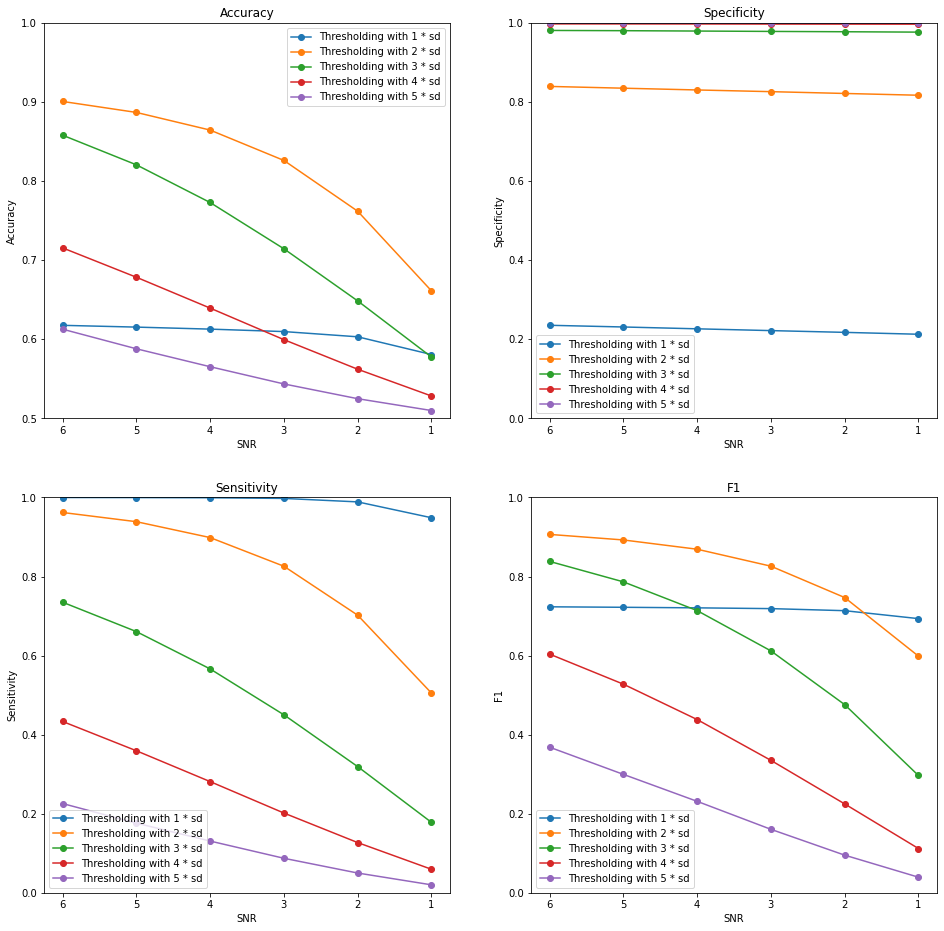

In [33]:
plt.rcParams['figure.figsize'] = [16, 16]

fig, axs = plt.subplots(2,2)

axs[0][0].title.set_text("Accuracy")
axs[0][1].title.set_text("Specificity")
axs[1][0].title.set_text("Sensitivity")
axs[1][1].title.set_text("F1")
axs[0][0].set_xlabel("SNR")
axs[0][1].set_xlabel("SNR")
axs[1][0].set_xlabel("SNR")
axs[1][1].set_xlabel("SNR")
axs[0][0].set_ylabel("Accuracy")
axs[0][1].set_ylabel("Specificity")
axs[1][0].set_ylabel("Sensitivity")
axs[1][1].set_ylabel("F1")

for sd in avgs["accuracy"]:
    axs[0][0].plot(avgs["accuracy"][sd].keys(), avgs["accuracy"][sd].values(), label=f"Thresholding with {sd} * sd", marker='o')
for sd in avgs["specificity"]:
    axs[0][1].plot(avgs["specificity"][sd].keys(), avgs["specificity"][sd].values(), label=f"Thresholding with {sd} * sd", marker='o')
for sd in avgs["sensitivity"]:
    axs[1][0].plot(avgs["sensitivity"][sd].keys(), avgs["sensitivity"][sd].values(), label=f"Thresholding with {sd} * sd", marker='o')
for sd in avgs["f1"]:
    axs[1][1].plot(avgs["f1"][sd].keys(), avgs["f1"][sd].values(), label=f"Thresholding with {sd} * sd", marker='o')

axs[0][0].legend()
axs[0][1].legend()
axs[1][0].legend()
axs[1][1].legend()

axs[0][0].set_ylim([0.5,1])
axs[0][1].set_ylim([0,1])
axs[1][0].set_ylim([0,1])
axs[1][1].set_ylim([0,1])
axs[0][0].invert_xaxis()
axs[0][1].invert_xaxis()
axs[1][0].invert_xaxis()
axs[1][1].invert_xaxis()

plt.show()
plt.rcParams['figure.figsize'] = [16, 8]       